# Predictions

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cv2

from glob import glob
from tqdm import tqdm
from skimage.io import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist import Rays_GoldenSpiral
from stardist.models import Config3D, StarDist3D, StarDistData3D
np.random.seed(42)
lbl_cmap = random_label_cmap()

from stardist import gputools_available
# import gputools
from skimage.measure import label
import skimage
from skimage import io
import tifffile

dtypes.py (526): Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
dtypes.py (527): Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
dtypes.py (528): Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
dtypes.py (529): Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
dtypes.py (530): Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
dtypes.py (535): Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Using TensorFlow

In [3]:
# read the dataset and normalise channels

Xname = sorted(glob('Antoine/raw/*.tiff'))
Yname = sorted(glob('Antoine/newGT/*.tiff'))
X = list(map(imread,Xname))
Y = list(map(imread,Yname))

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]

100%|██████████| 11/11 [01:41<00:00,  9.21s/it]


In [3]:
# testing images

X_val = [X[0], X[1], X[7], X[8], X[10]]
Y_val = [Y[0], Y[1], Y[7], Y[8], Y[10]]

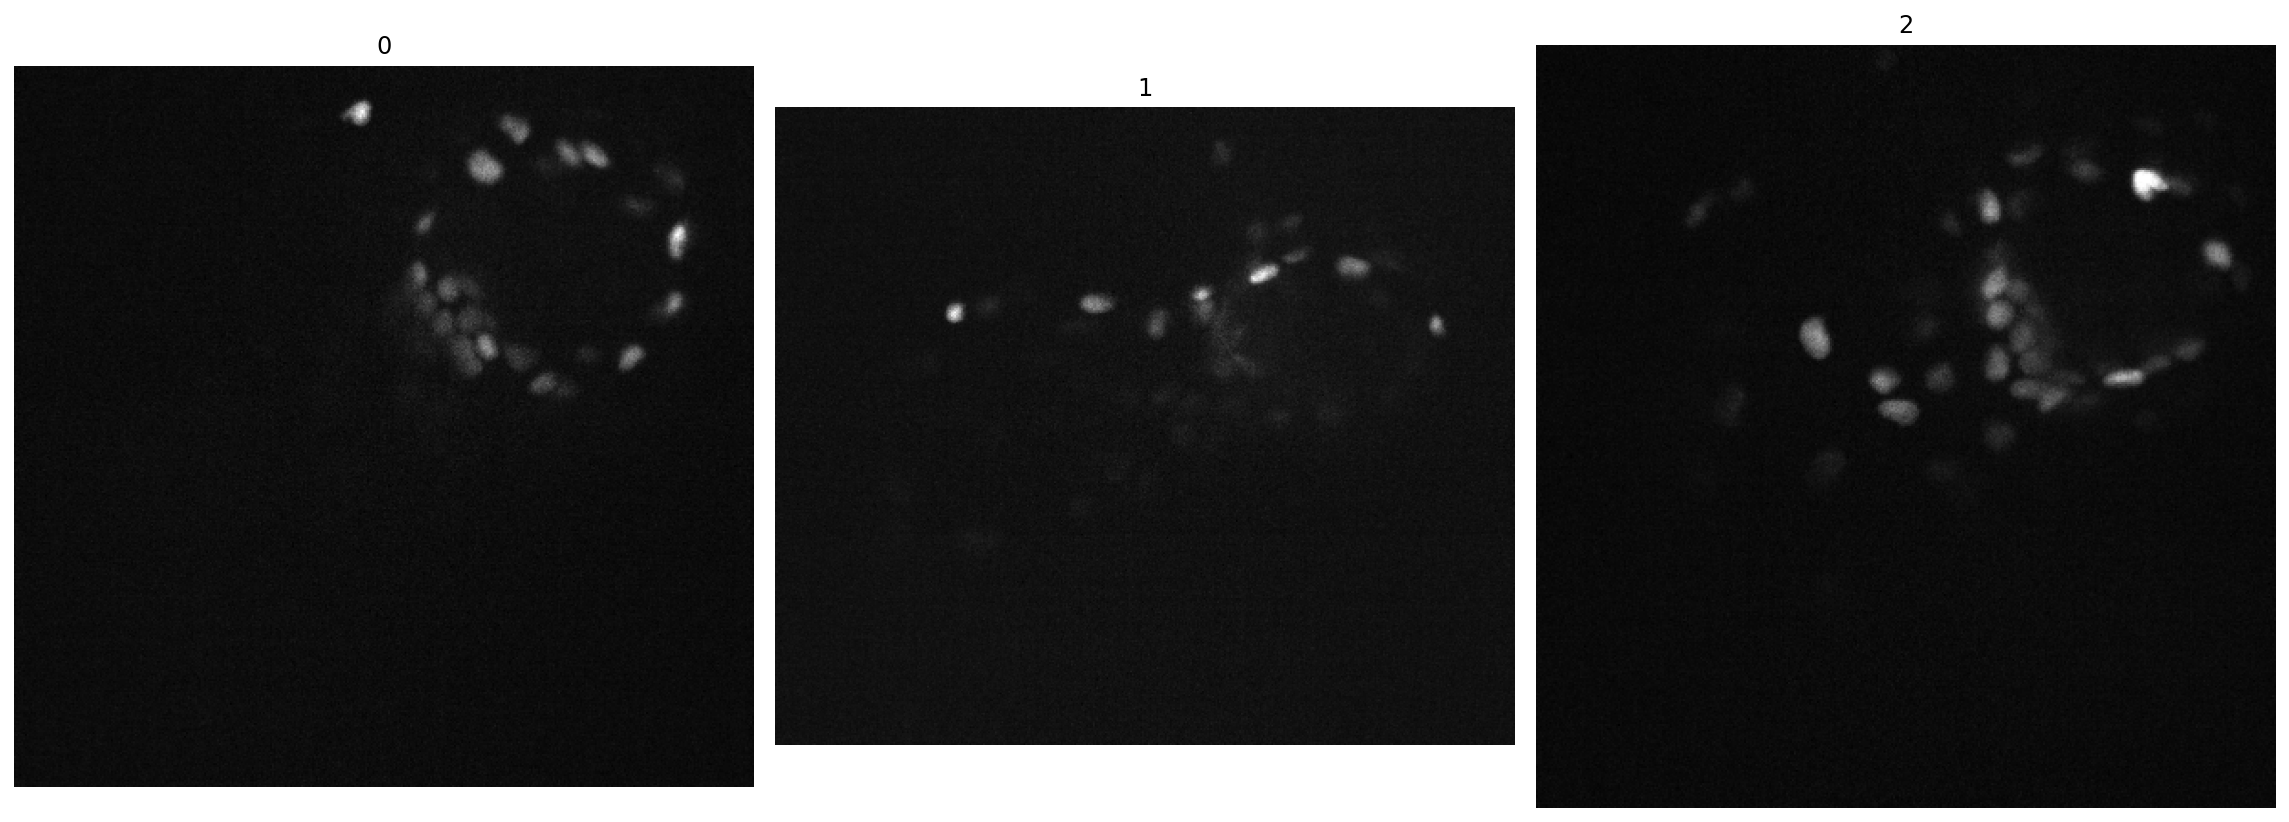

In [5]:
# show some test images

if True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [4]:
# load model

model = StarDist3D(None, name='stardist3D_iter1', basedir='models')

Instructions for updating:
Colocations handled automatically by placer.
Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [ ]:
# run model prediction for the 5 testing images

Y_val_pred = [model.predict_instances(x, n_tiles = (3,3,3), show_tile_progress=True)[0] 
              for x in tqdm(X_val)]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  4%|▎         | 1/27 [01:26<37:18, 86.09s/it]

  7%|▋         | 2/27 [02:46<34:31, 82.87s/it]

 11%|█         | 3/27 [04:05<32:21, 80.91s/it]

 15%|█▍        | 4/27 [05:21<30:21, 79.20s/it]

 19%|█▊        | 5/27 [06:36<28:30, 77.73s/it]

 22%|██▏       | 6/27 [07:51<26:50, 76.70s/it]

 26%|██▌       | 7/27 [09:08<25:36, 76.84s/it]

 30%|██▉       | 8/27 [10:28<24:34, 77.59s/it]

 33%|███▎      | 9/27 [11:45<23:14, 77.46s/it]

 37%|███▋      | 10/27 [13:04<22:08, 78.14s/it]

 41%|████      | 11/27 [14:23<20:50, 78.18s/it]

 44%|████▍     | 12/27 [15:45<19:51, 79.44s/it]

 48%|████▊     | 13/27 [17:09<18:49, 80.70s/it]

 52%|█████▏    | 14/27 [18:26<17:17, 79.83s/it]

 56%|█████▌    | 15/27 [19:45<15:53, 79.49s/it]

 59%|█████▉    | 16/27 [21:10<14:51, 81.06s/it]

 63%|██████▎   | 17/27 [22:34<13:40, 82.02s/it]

 67%|██████▋   | 18/27 [23:56<12:18, 82.07s/it]

 70%|███████   | 19/27 [25:21<11:02, 82.83s/it]

In [ ]:
# Save predictions as a binarised tiff file 

import skimage.morphology as morph
import tifffile 

Yname1 = ['Antoine/wt/wt-heart 2 dpf-e2_25_pred.tiff',
          'Antoine/wt/wt-heart 2 dpf-e4_25_pred.tiff',
          'Antoine/wt/wt-heart 2 dpf-e6_25_pred.tiff',
          'Antoine/wt/wt-heart 2 dpf-e7_25_pred.tiff',
          'Antoine/wt/wt-heart 2 dpf-e8_25_pred.tiff']

def label_separating_for_binary(labels):
    label_copy = np.copy(labels)
#     dilation = morph.dilation(label_copy, footprint=morph.ball(1)) # ball of radius 1 corresponds to connectivity 1
    dilation = morph.dilation(label_copy) # ball of radius 1 corresponds to connectivity 1
    difference = dilation - label_copy    # You look which voxels take a different value after the dilation operation. These form the 'border' of each nuclei.
    label_copy[difference != 0] = 0       # All the voxels on the borders are set to 0
    return label_copy != 0                # The volume is binarized here

# display binary prediction and save 
i = 0
z = 135
for i in range(len(Y_val_pred)):
    Y1 = label_separating_for_binary(Y_val_pred[i][:][:][:])
    print(Yname1[i])
    plt.figure(figsize=(8,8))
    plt.imshow(Y1[z],cmap='gray'); plt.axis('off'); plt.title('Binary Mask')
    Y1 = Y1.astype('uint8')
    print(Y1.dtype)
    print(np.unique(Y1))
    tifffile.imsave(Yname1[i], Y1)
None;


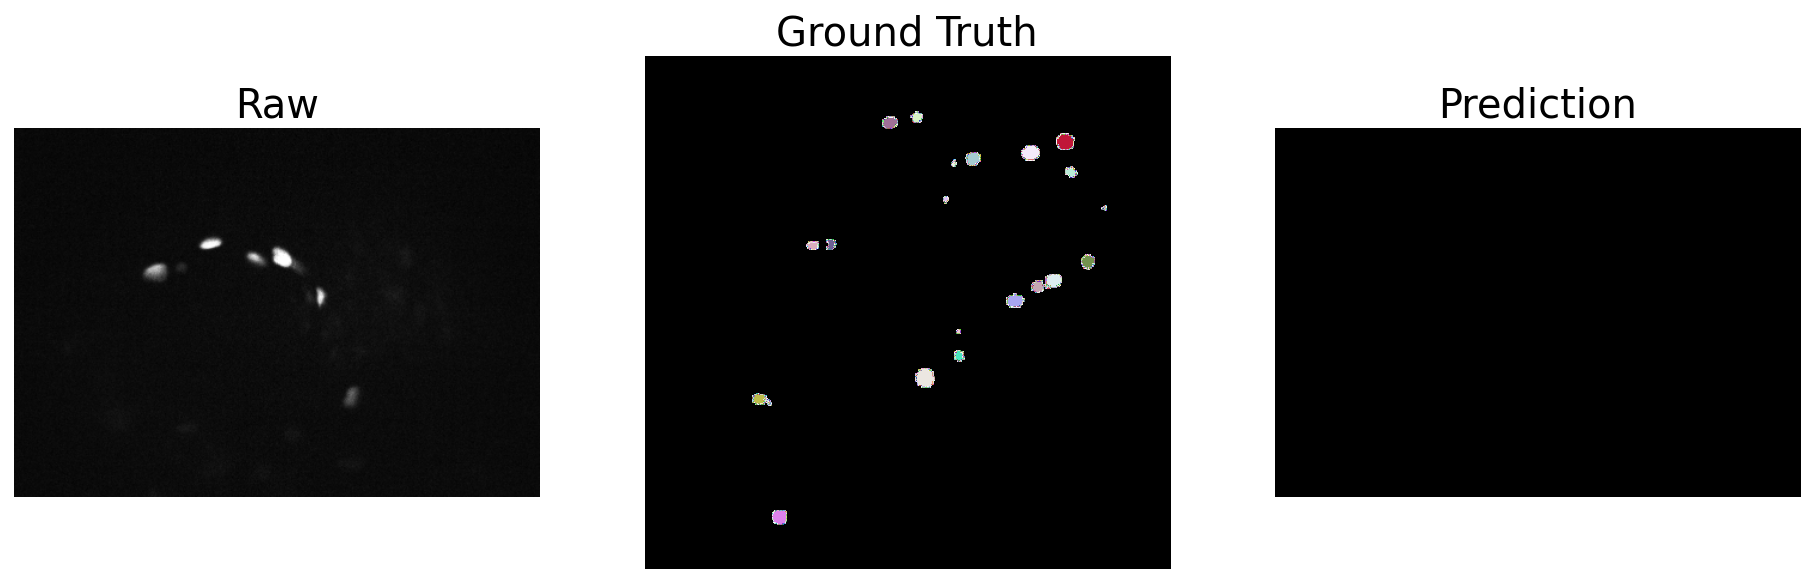

In [15]:
# Display the predictions against the raw image and ground truth
for i in range(len(X_val)):
    Y_val[i] = label(Y_val[i], connectivity=1)
    Y_val_pred[i] = label(Y_val_pred[i], connectivity=1)
    img, lbl = X_val[i],Y_val[i]
    z=142
    plt.figure(figsize=(16,10)) 
    plt.title('Model Prediction for Mutant and Wild-Type Dataset, Stardist_iter1', fontsize=20)
    plt.subplot(131); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw',  fontsize=20)
    plt.subplot(132); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('Ground Truth',  fontsize=20)
    plt.subplot(133); plt.imshow(Y_val_pred[i][z],cmap=lbl_cmap); plt.axis('off'); plt.title('Prediction', fontsize=20)
#     plt.savefig(Yname1[i])

In [49]:
# metrics

taus = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

for t in taus:
    print('IoU:', t, '\n', stats[taus.index(t)])

IoU: 0 
 DatasetMatching(criterion='iou', thresh=0, fp=284, tp=982, fn=0, precision=0.7756714060031595, recall=1.0, accuracy=0.7756714060031595, f1=0.8736654804270463, n_true=982, n_pred=1266, mean_true_score=0.7101132534671947, mean_matched_score=0.7101132534671947, panoptic_quality=0.6204014367480295, by_image=False)
IoU: 0.1 
 DatasetMatching(criterion='iou', thresh=0.1, fp=298, tp=968, fn=14, precision=0.764612954186414, recall=0.9857433808553971, accuracy=0.75625, f1=0.8612099644128114, n_true=982, n_pred=1266, mean_true_score=0.7095696707607044, mean_matched_score=0.7198320420320369, panoptic_quality=0.6199265273016118, by_image=False)
IoU: 0.2 
 DatasetMatching(criterion='iou', thresh=0.2, fp=320, tp=946, fn=36, precision=0.7472353870458136, recall=0.9633401221995926, accuracy=0.7265745007680492, f1=0.8416370106761566, n_true=982, n_pred=1266, mean_true_score=0.7061592614820679, mean_matched_score=0.733032129783711, panoptic_quality=0.616946970440739, by_image=False)
IoU: 0.3 
 

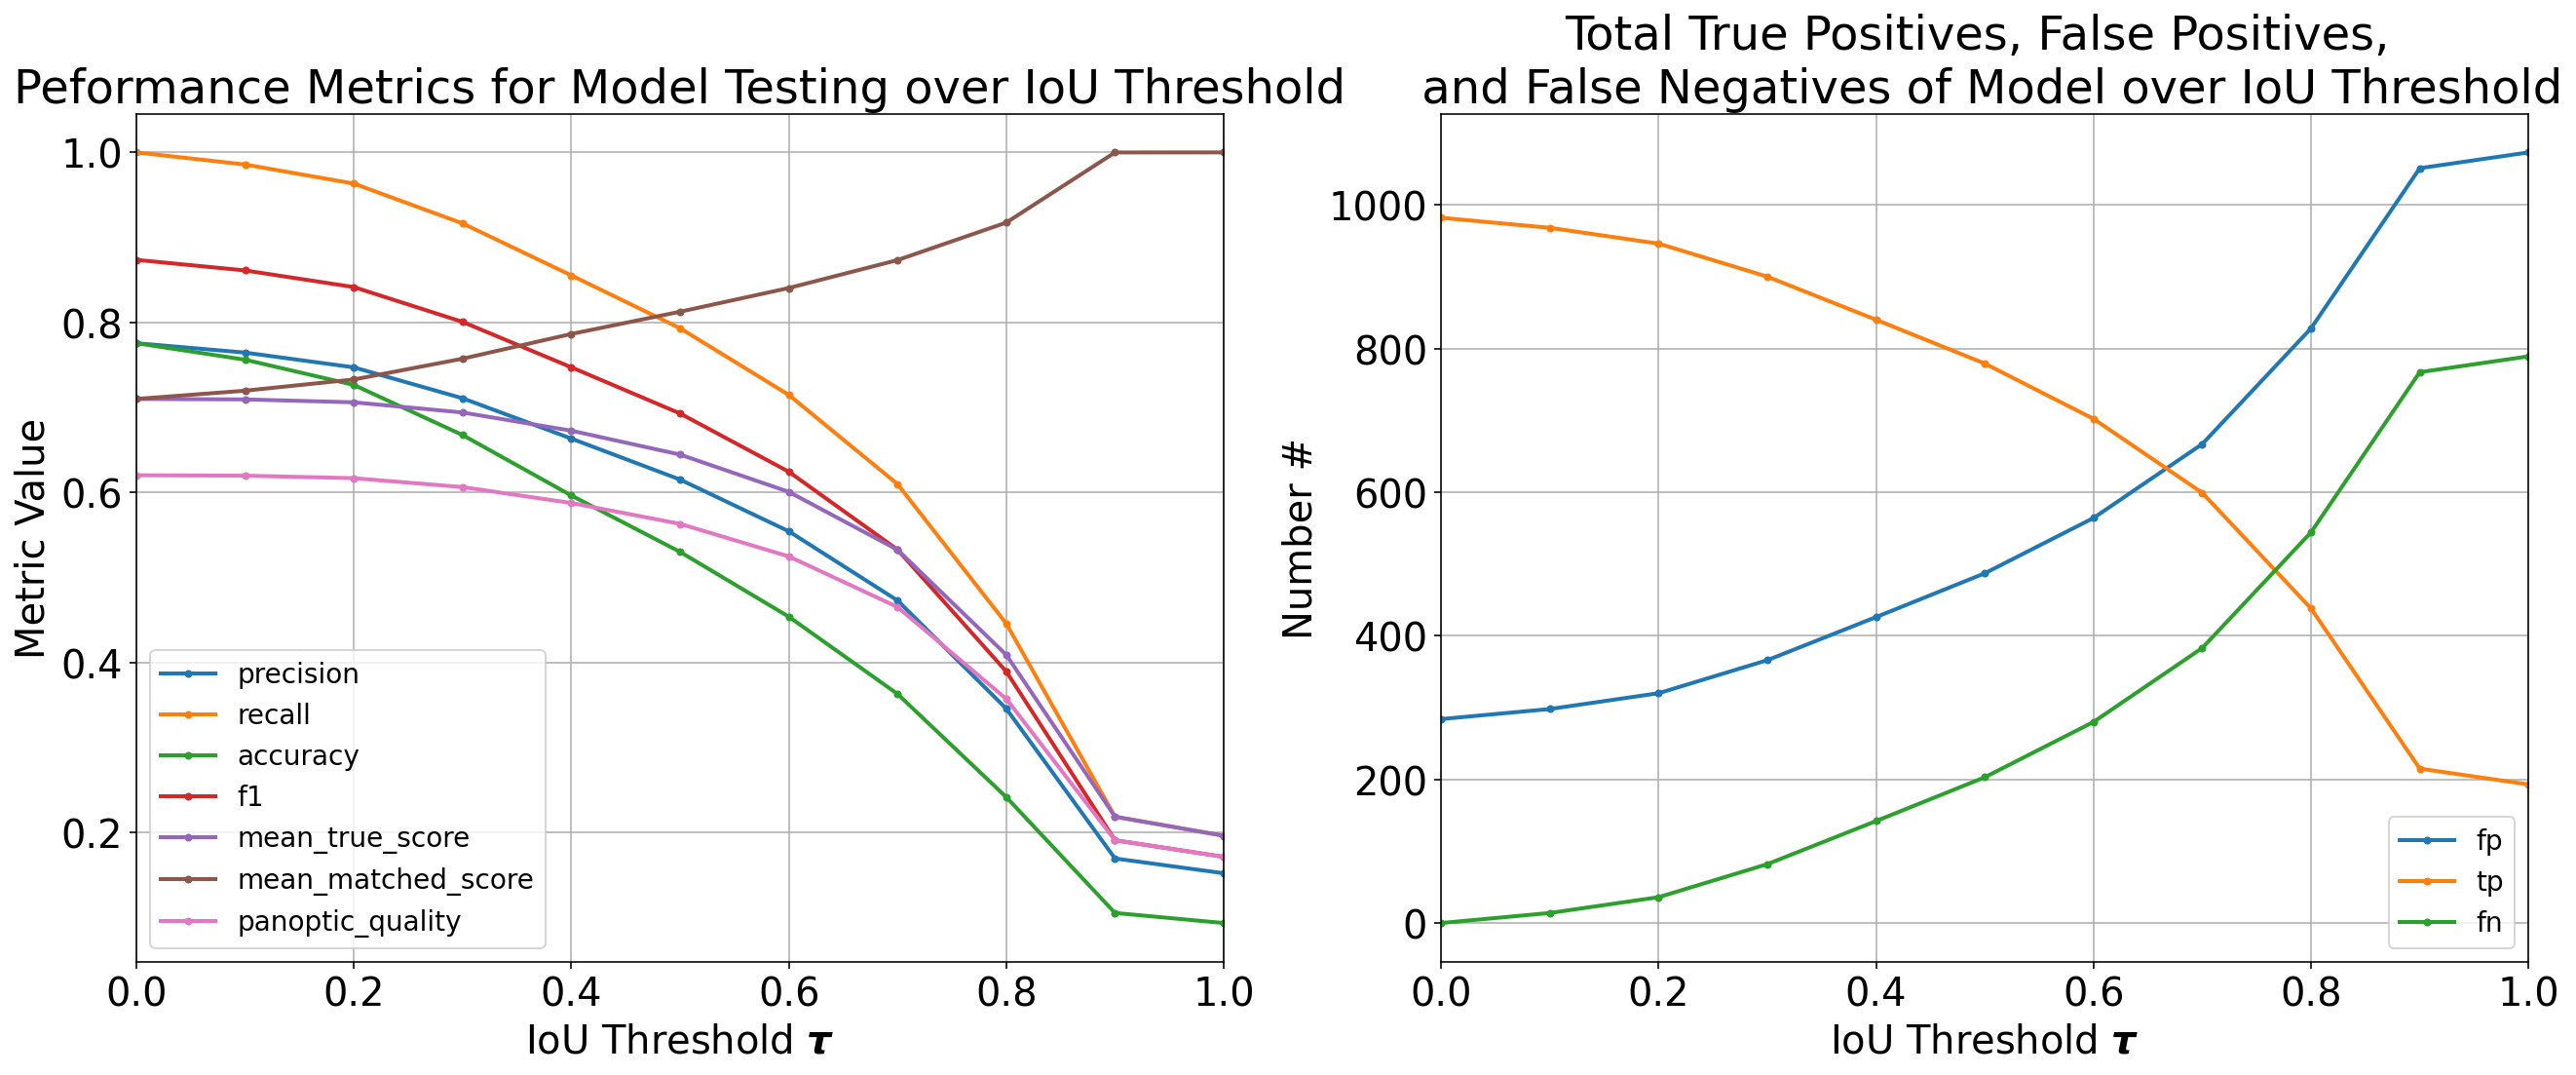

In [47]:
# Plotting the performance metrics against IoU threshold for model testing
import matplotlib 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(22,8))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU Threshold $\tau$')
ax1.set_ylabel('Metric Value')
ax1.grid()
ax1.legend(fontsize=14)
ax1.set_title('Peformance Metrics for Model Testing over IoU Threshold')
ax1.set_xlim(0, 1)

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU Threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.set_title('Total True Positives, False Positives, \n and False Negatives of Model over IoU Threshold')
ax2.legend(fontsize=14);
# ax1.set_xlim([0 1])
ax2.set_xlim(0, 1)

plt.savefig('metrics_stardist_iter1.png')

# Now predict for remaining images in the dataset

In [ ]:
Yname1 = ['Antoine/Validation/mutant_e2.tiff','Antoine/Validation/mutant_e2.tiff', 
          'Antoine/Validation/mutant_e8.tiff', 'Antoine/Validation/wt_e1.tiff', 
          'Antoine/Validation/wt_e2.tiff']

def label_separating_for_binary(labels):
    label_copy = np.copy(labels)
#     dilation = morph.dilation(label_copy, footprint=morph.ball(1)) # ball of radius 1 corresponds to connectivity 1
    dilation = morph.dilation(label_copy) # ball of radius 1 corresponds to connectivity 1
    difference = dilation - label_copy # You look which voxels take a different value after the dilation operation. These form the 'border' of each nuclei.
    label_copy[difference != 0] = 0 # All the voxels on the borders are set to 0
    return label_copy != 0 # The volume is binarized here

i = 0
z = 135
for i in range(len(Y_val_pred)):
    Y1 = label_separating_for_binary(Y_val_pred[i][:][:][:])
    print(Yname1[i])
    plt.figure(figsize=(8,8))
    plt.imshow(Y1[z],cmap='gray'); plt.axis('off'); plt.title('Binary Mask')
    Y1 = Y1.astype('uint8')
    print(Y1.dtype)
    print(np.unique(Y1))
    tifffile.imsave(Yname1[i], Y1)
None;

i=0
for i in range(len(X_val)):
    Y_val[i] = label(Y_val[i], connectivity=1)
    Y_val_pred[i] = label(Y_val_pred[i], connectivity=1)
    img, lbl = X_val[i],Y_val[i]
    z=140
    plt.figure(figsize=(16,10))
    plt.subplot(131); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw')
    plt.subplot(132); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('Ground Truth')
    plt.subplot(133); plt.imshow(Y_val_pred[i][z],cmap=lbl_cmap); plt.axis('off'); plt.title('Predicted')